In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, moca, Rc_finder, tangential_velocity

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None


In [2]:
def find_root(x, y):
    coeffs = np.polyfit(x, y, 3)
    roots = np.roots(np.poly1d(coeffs))
    real_roots = roots[np.isreal(roots)].real
    mid = x[len(x)//2]
    return real_roots[np.argmin(np.abs(mid - real_roots))]

def tang_at_root(x, y, rx):
    coeffs = np.polyfit(x, y, 3)
    deriv = np.polyder(coeffs)
    slope = np.polyval(deriv, rx)
    intercept = np.polyval(coeffs, rx) - slope * rx
    return slope, intercept

def cubic_interpolate(x, y, root):
    coeffs = np.polyfit(x, y, 3)
    return np.polyval(coeffs, root)

def unit_det(Q, symmetrize=True):
    Q = np.asarray(Q, dtype=float)
    d = np.linalg.det(Q)
    if not np.isfinite(d) or d <= 0: raise ValueError("det(Q) must be positive and finite")
    s = 1/np.sqrt(d)
    return s*Q, s

def circle(xc, yc, r, n=200):
    theta = np.linspace(0, 2*np.pi, n)
    x = xc + r * np.cos(theta)
    y = yc + r * np.sin(theta)
    return x, y
    

In [3]:
width=500
x = np.linspace(-width // 2, width // 2, 101)
y = np.linspace(-width // 2, width // 2, 101)
X, Y = np.meshgrid(x, y, indexing='ij')

xc, yc = 0.0, 0.0
Q11, Q12, Q22 = 1, 0, 1
psi0 = 250.0
Rc = 85.0
A = - psi0 / Rc**2

# rescale Q to have unit determinant
Q, _ = unit_det(Q=np.array([[Q11, Q12], [Q12, Q22]]))
q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]

df_res = pd.DataFrame({'xc': [xc], 'yc': [yc], 'w': [2*A*(q11+q22)*1e-3], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                        'Rc': [Rc], 'psi0': [psi0], 'A': [A]})

dx, dy = X - xc, Y - yc
rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
Qr2 = (q11*dx + q12*dy)**2 + (q12*dx + q22*dy)**2 # ||Qr||
psi = psi0 * np.exp( - rho2 / Rc**2 )
u =   psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q12*dx + 2*q22*dy ) / Rc**2
v = - psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q11*dx + 2*q12*dy ) / Rc**2

df_res


,xc,yc,w,q11,q12,q22,Rc,psi0,A
0,0.0,0.0,-0.000138,1.0,0.0,1.0,85.0,250.0,-0.034602


(np.float64(-275.0), np.float64(275.0), np.float64(-275.0), np.float64(275.0))

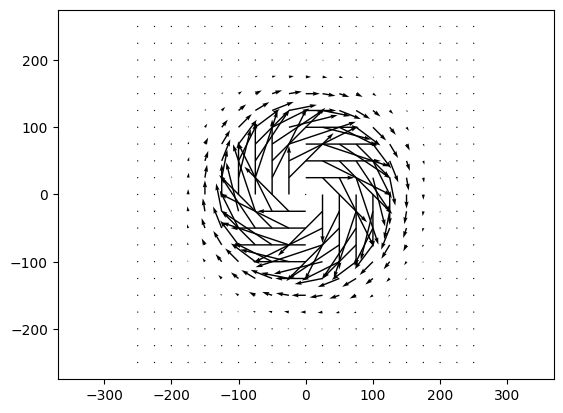

In [4]:
spac = 5
plt.quiver(X[::spac, ::spac], Y[::spac, ::spac], u[::spac, ::spac], v[::spac, ::spac])
plt.axis('equal')


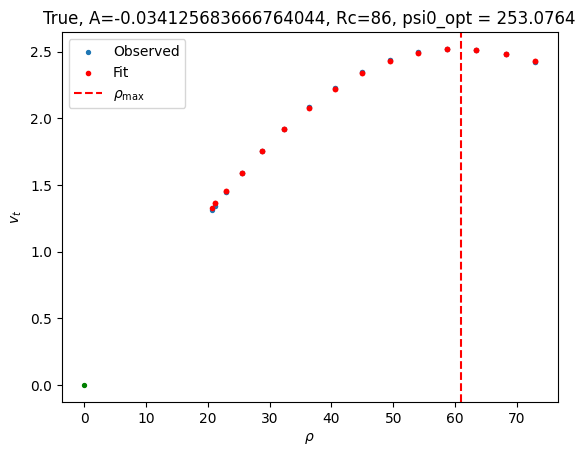

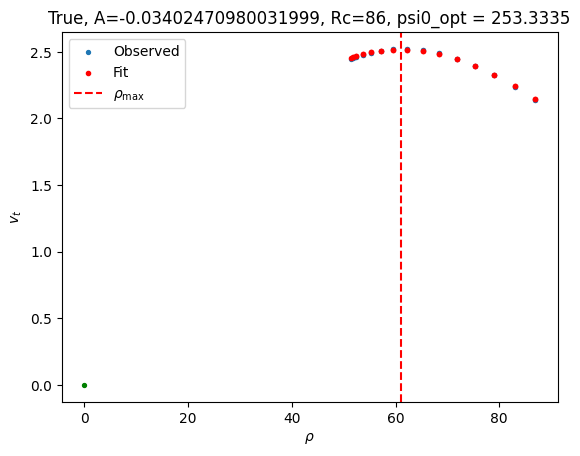

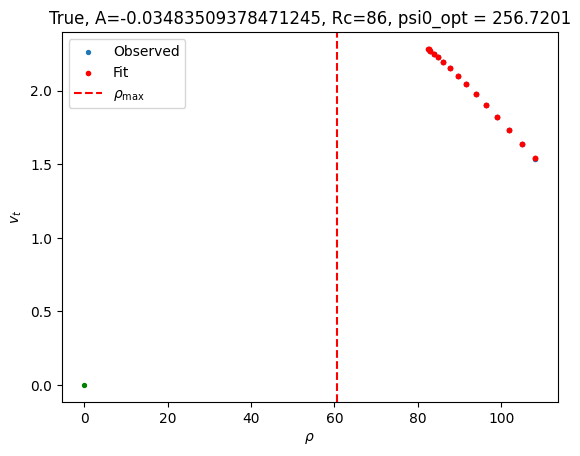

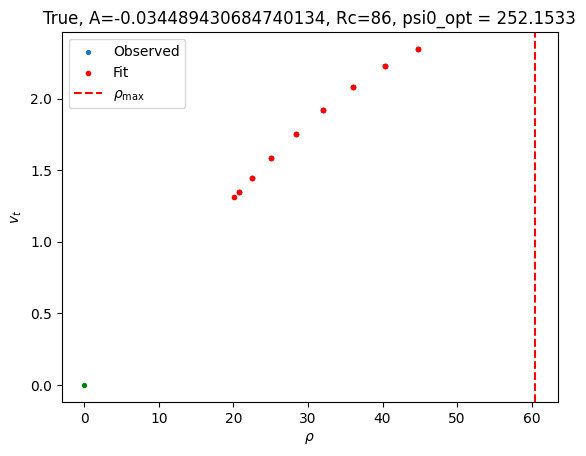

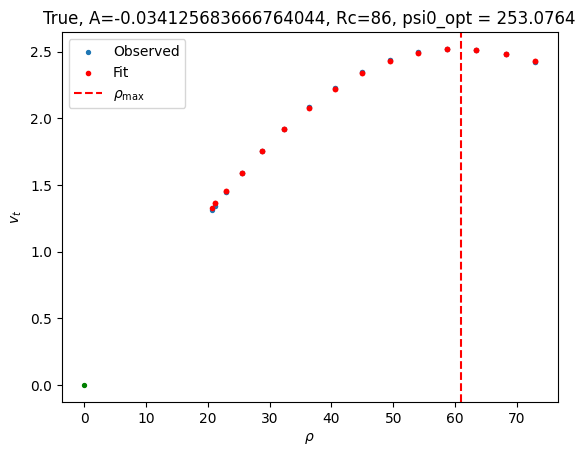

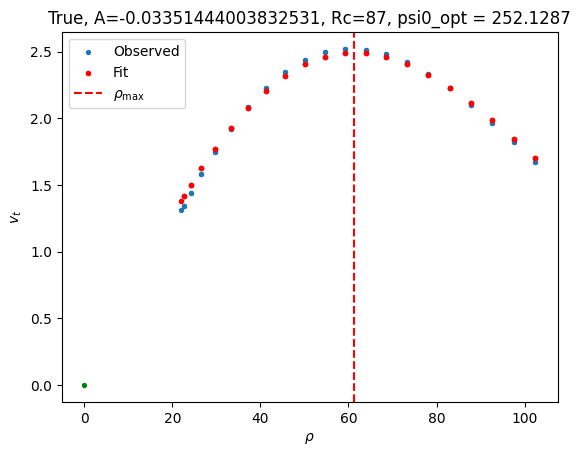

,xc,yc,w,q11,q12,q22,Rc,psi0,A
Control,0.000000e+00,0.000000,-0.000138,1.0,0.0,1.0,85.000000,250.000000,-0.034602
P1,-2.842171e-14,-0.602418,-0.000125,1.0,-0.0,1.0,86.116262,253.076433,-0.034126
P2,2.842171e-14,-1.506044,-0.000093,1.0,-0.0,1.0,86.287746,253.333531,-0.034025
P3,1.421085e-14,-2.409670,-0.000054,1.0,-0.0,1.0,85.846278,256.720128,-0.034835
L1,7.105427e-15,-0.080577,-0.000130,1.0,-0.0,1.0,85.504561,252.153262,-0.034489
L2,-2.842171e-14,-0.602418,-0.000125,1.0,-0.0,1.0,86.116262,253.076433,-0.034126
L3,7.105427e-14,-1.999500,-0.000113,1.0,-0.0,1.0,86.735151,252.128678,-0.033514


In [5]:
nic, njc = 50, 60
r = 14

df_tests = pd.DataFrame({
    'nic': [nic, nic, nic, nic, nic, nic],
    'njc': [54, njc, 66, 54, 54, 54],
    'r': [r, r, r, 8, r, 20]
}, index=['P1', 'P2', 'P3', 'L1', 'L2', 'L3'])

dic_tests = {}
for test in df_tests.index:
    data = df_tests.loc[test]

    x1 = x[data.nic-data.r:data.nic+data.r+1]
    y1 = np.array([y[data.njc]] * len(x1))
    l = x1 - x1[0]
    
    u1 = u[data.nic-data.r:data.nic+data.r+1, data.njc]
    v1 = v[data.nic-data.r:data.nic+data.r+1, data.njc]

    l0, r0, w_moc, Q_moc, Rc_moc, psi0_moc, A_moc = moca(l, u1, v1, plot_flag=True)
    xc_moc, yc_moc = l0 + x1[0], r0 + y1[0]
    w_moc *= 1e-3
                      
    dic_tests[test] = {'x1': x1, 'y1': y1, 'l': l, 'u1': u1, 'v1': v1, 'name': test}
    df_res.loc[len(df_res)] = {'xc': xc_moc, 'yc': yc_moc, 'w': w_moc,
                               'q11': Q_moc[0,0], 'q12': Q_moc[0,1], 'q22': Q[1,1],
                               'Rc': Rc_moc, 'psi0': psi0_moc, 'A': A_moc}
    
df_res.index = ['Control'] +  list(df_tests.index)
df_res


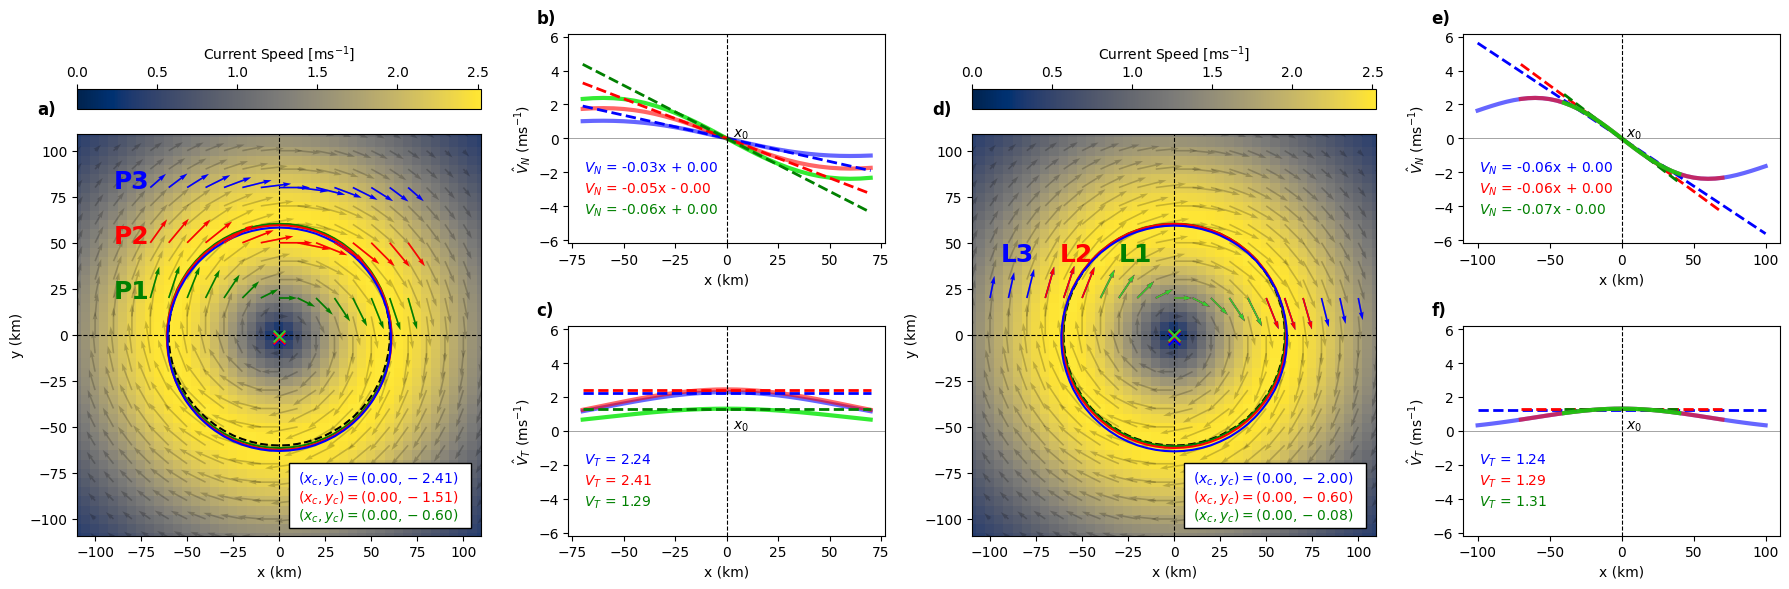

In [6]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(2, 6, figure=fig, width_ratios=[1, 1, 2, 1, 1, 2])  # Adjust width ratios

# LEFT PLOT (PLOT A)
ax_main_left = fig.add_subplot(gs[:, :2])
pc = ax_main_left.pcolor(x, y, np.hypot(u, v), cmap='cividis', zorder=0)
plt.colorbar(pc, ax=ax_main_left, orientation='horizontal', location='top', label=r'Current Speed [ms$^{-1}$]')
ax_main_left.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=0)
ax_main_left.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=0)

spacing = 2
scale = 30
width = 0.004
alpha = 1
quiv = ax_main_left.quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
                           alpha=.2, scale=scale, width=width, zorder=1)

# x_circ, y_circ = circle(xc, yc, Rc)
# ax_main_left.plot(x_circ, y_circ, color='k', ls='--')
ax_main_left.contour(X, Y, rho2, levels=[Rc**2/2],
                     colors='k', linestyles='--')

colors = ['limegreen', 'r', 'b']
color = ['g', 'r', 'b']
color_fits = [(0, .9, 0, 0.8), (1, 0, 0, 0.6), (0, 0, 1, 0.6)]
i = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:
        x1, y1, l, u1, v1 = dic['x1'], dic['y1'], dic['l'], dic['u1'], dic['v1']
        data = df_res.loc[dic['name']]
        
        ax_main_left.text(x1[0]-20, y1[0], dic['name'], color=color[i],
                          zorder=3, fontsize=18, fontweight='bold')
        ax_main_left.quiver(x1[::spacing], y1[::spacing],
                            u1[::spacing], v1[::spacing],
                            scale=scale, width=width, color=color[i], zorder=3)
        ax_main_left.scatter(data.xc, data.yc, color=colors[i], marker='x', s=70, zorder=10-extract_number(dic['name']))

        # x_circ, y_circ = circle(data.xc, data.yc, data.Rc)
        # ax_main_left.plot(x_circ, y_circ, color=colors[i])
        dx_ell, dy_ell = X - data.xc, Y - data.yc
        rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
        ax_main_left.contour(X, Y, rho2_ell, levels=[data.Rc**2/2], colors=color[i])
        
        ax_main_left.text(10, -100 + 10*i, fr'$(x_c,y_c)=({np.abs(data.xc):.2f},{data.yc:.2f})$',
                          color=color[i], zorder=10)

        i += 1
        
x_pos, y_pos = 0.75, 0.1
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_left.transAxes,
                       facecolor='white', edgecolor='black', zorder=9)
ax_main_left.add_patch(rect)
ax_main_left.axis('equal')
ax_main_left.set_xlim(-100, 100)
ax_main_left.set_ylim(-100, 100)
ax_main_left.set_xlabel('x (km)')
ax_main_left.set_ylabel('y (km)')
ax_main_left.text(-0.1, 1.05, 'a)', transform=ax_main_left.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_left = fig.add_subplot(gs[0, 2])
ax3_left = fig.add_subplot(gs[1, 2])

# color_fits = [(0, 1, 0, 0.6), (1, 0, 0, 0.6), (0, 0, 1, 0.6)]
j = 0
for dic in dic_tests.values():
    if 'P' in dic['name']:

        x1, y1, l, u1, v1 = dic['x1'], dic['y1'], dic['l'], dic['u1'], dic['v1']
        data = df_res.loc[dic['name']]
        
        root = find_root(x1, v1)
        c, b = tang_at_root(x1, v1, root)
        a = cubic_interpolate(x1, u1, root)

        ax2_left.text(0.05, 0.2 + 0.1 * j, fr"$V_N$ = {c:.2f}x {'+' if b > 0 else '-'} {abs(b):.2f}", transform=ax2_left.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])
        ax3_left.text(0.05, 0.2 + 0.1 * j, fr"$V_T$ = {a:.2f}", transform=ax3_left.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])

        root = find_root(x1, v1)
        c, b = tang_at_root(x1, v1, root)
        a = cubic_interpolate(x1, u1, root)

        p_v1 = c*x1 + b
        p_u1 = [a]*len(x1)

        ax2_left.plot(x1, v1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name'])-3)
        ax2_left.plot(x1, p_v1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))

        ax3_left.plot(x1, u1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name'])-3)
        ax3_left.plot(x1, p_u1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name']))
        j += 1

ax2_left.text(3, .13, r'$x_0$')
ax3_left.text(3, .13, r'$x_0$')
        
ax2_left.axvline(x1[len(x1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_left.set_ylabel(r'$\hat{V}_N$ (ms$^{-1}$)')
ax2_left.set_xlabel('x (km)')
ax2_left.text(-0.1, 1.05, 'b)', transform=ax2_left.transAxes, fontsize=12, fontweight='bold')
ax3_left.axvline(x1[len(x1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_left.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_left.set_ylabel(r'$\hat{V}_T$ (ms$^{-1}$)')
ax3_left.set_xlabel('x (km)')
ax3_left.text(-0.1, 1.05, 'c)', transform=ax3_left.transAxes, fontsize=12, fontweight='bold')

# Right PLOT (PLOT B)
ax_main_right = fig.add_subplot(gs[:, 3:5])
pc = ax_main_right.pcolor(x, y, np.hypot(u, v), cmap='cividis')
plt.colorbar(pc, ax=ax_main_right, orientation='horizontal', location='top', label=r'Current Speed [ms$^{-1}$]')
ax_main_right.axhline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
ax_main_right.axvline(0, color='black', linewidth=0.8, linestyle='--', zorder=2)
quiv = ax_main_right.quiver(x[::spacing], y[::spacing],
                            u[::spacing, ::spacing].T, v[::spacing, ::spacing].T,
                            alpha=.2, scale=scale, width=width)

# x_circ, y_circ = circle(xc, yc, Rc)
# ax_main_right.plot(x_circ, y_circ, color='k', ls='--')
ax_main_right.contour(X, Y, rho2, levels=[Rc**2/2],
                     colors='k', linestyles='--')

i = 0
for dic in dic_tests.values():
    if 'L' in dic['name']:
        x1, y1, l, u1, v1 = dic['x1'], dic['y1'], dic['l'], dic['u1'], dic['v1']
        data = df_res.loc[dic['name']]
        
        ax_main_right.quiver(x1[::spacing], y1[::spacing],
                             u1[::spacing], v1[::spacing],
                             scale=scale, width=width, color=colors[i], zorder=5-i)
        ax_main_right.scatter(data.xc, data.yc, color=colors[i], marker='x', s=70, zorder=10-extract_number(dic['name']))
        ax_main_right.text(10, -100 + 10*i, fr'$(x_c,y_c)=({np.abs(data.xc):.2f},{data.yc:.2f})$',
                           color=color[i], zorder=10)

        # x_circ, y_circ = circle(data.xc, data.yc, data.Rc)
        # ax_main_right.plot(x_circ, y_circ, color=colors[i])
        dx_ell, dy_ell = X - data.xc, Y - data.yc
        rho2_ell = data.q11*dx_ell**2 + 2*data.q12*dx_ell*dy_ell + data.q22*dy_ell**2
        ax_main_right.contour(X, Y, rho2_ell, levels=[data.Rc**2/2], colors=color[i])

        ax_main_right.text(x1[0]-i*2 +10, y1[0]+20, dic['name'],
                           color=color[i], zorder=3, fontsize=18, fontweight='bold')
 
        i += 1
x_pos, y_pos = 0.75, 0.1
box_width = 0.45  # Adjust width as needed
box_height = 0.16 #0.07  # Adjust height as needed
rect = Rectangle((x_pos - box_width / 2, y_pos - box_height / 2), 
                       box_width, box_height, transform=ax_main_right.transAxes,
                       facecolor='white', edgecolor='black', zorder=9)
ax_main_right.add_patch(rect)
ax_main_right.axis('equal')
ax_main_right.set_xlim(-100, 100)
ax_main_right.set_ylim(-100, 100)
ax_main_right.set_xlabel('x (km)')
ax_main_right.set_ylabel('y (km)')
ax_main_right.text(-0.1, 1.05, 'd)', transform=ax_main_right.transAxes, fontsize=12, fontweight='bold')

# Subplot columns (2x1 on the right)
ax2_right = fig.add_subplot(gs[0, 5])
ax3_right = fig.add_subplot(gs[1, 5])

j = 0
for dic in dic_tests.values():
    if 'L' in dic['name']:
        x1, y1, l, u1, v1 = dic['x1'], dic['y1'], dic['l'], dic['u1'], dic['v1']
        data = df_res.loc[dic['name']]
        
        root = find_root(x1, v1)
        c, b = tang_at_root(x1, v1, root)
        a = cubic_interpolate(x1, u1, root)

        ax2_right.text(0.05, 0.2 + 0.1 * j, fr"$V_N$ = {c:.2f}x {'+' if b > 0 else '-'} {abs(b):.2f}", transform=ax2_right.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])
        ax3_right.text(0.05, 0.2 + 0.1 * j, fr"$V_T$ = {a:.2f}", transform=ax3_right.transAxes,
         fontsize=10, verticalalignment='top', color=color[j])

        root = find_root(x1, v1)
        c, b = tang_at_root(x1, v1, root)
        a = cubic_interpolate(x1, u1, root)

        p_v1 = c*x1 + b
        p_u1 = [a]*len(x1)

        ax2_right.plot(x1, v1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax2_right.plot(x1, p_v1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name'])-3)

        ax3_right.plot(x1, u1, color=color_fits[j], linewidth=3, zorder=-extract_number(dic['name']))
        ax3_right.plot(x1, p_u1, color=color[j], linestyle='--', linewidth=2, zorder=-extract_number(dic['name'])-3)

        j += 1

ax2_right.text(3, .13, r'$x_0$')
ax3_right.text(3, .13, r'$x_0$')

ax2_right.axvline(x1[len(x1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax2_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax2_right.set_ylabel(r'$\hat{V}_N$ (ms$^{-1}$)')
ax2_right.text(-0.1, 1.05, 'e)', transform=ax2_right.transAxes, fontsize=12, fontweight='bold')
ax2_right.set_xlabel('x (km)')

ax3_right.axvline(x1[len(x1) // 2], color='black', linewidth=0.8, linestyle='--', zorder=2)
ax3_right.axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
ax3_right.set_ylabel(r'$\hat{V}_T$ (ms$^{-1}$)')
ax3_right.set_xlabel('x (km)')
ax3_right.text(-0.1, 1.05, 'f)', transform=ax3_right.transAxes, fontsize=12, fontweight='bold')
ax3_right.set_xlabel('x (km)')


axs = [ax2_left, ax3_left, ax2_right, ax3_right]
ymin, ymax = np.inf, -np.inf
for ax in axs:
    ymin = min(ymin, ax.get_ylim()[0])
    ymax = max(ymax, ax.get_ylim()[1])

for ax in axs:
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()


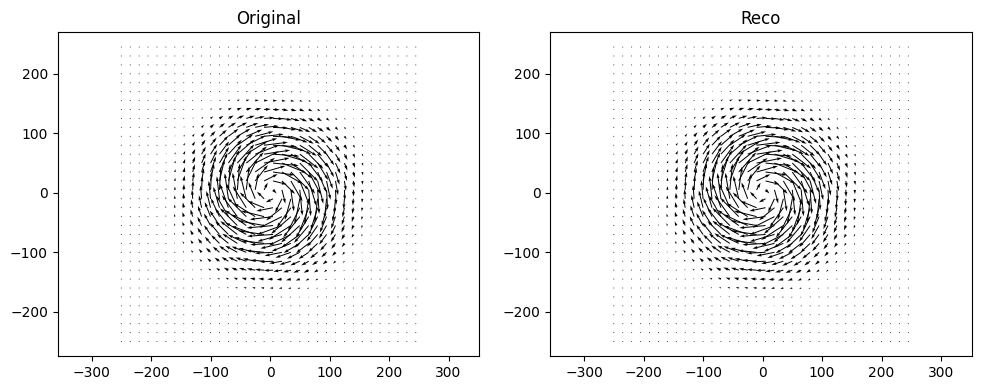

In [7]:
data = df_res.iloc[5]

spac, scale = 3, 40
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].quiver(
    x[::spac], y[::spac],
    u[::spac, ::spac].T, v[::spac, ::spac].T,
    scale=scale,
)
axs[0].axis('equal')
# axs[0].set_xlim(-75, 75)
# axs[0].set_ylim(-75, 75)
axs[0].set_title('Original')

dx, dy = X - data.xc, Y - data.yc
rho2 = data.q11*dx**2 + 2*data.q12*dx*dy + data.q22*dy**2
psi = data.psi0 * np.exp( - rho2 / data.Rc**2 )
u_reco =   data.psi0 * np.exp( - rho2 / data.Rc**2 ) * ( 2*data.q12*dx + 2*data.q22*dy ) / data.Rc**2
v_reco = - data.psi0 * np.exp( - rho2 / data.Rc**2 ) * ( 2*data.q11*dx + 2*data.q12*dy ) / data.Rc**2

axs[1].quiver(X[::spac,::spac], Y[::spac,::spac], u_reco[::spac,::spac], v_reco[::spac,::spac], scale=scale)
axs[1].axis('equal')
# axs[1].set_xlim(-75, 75)
# axs[1].set_ylim(-75, 75)
axs[1].set_title('Reco')

plt.tight_layout()
